In [2]:
# STEP 1: Install libraries (if needed)
!pip install -q scikit-learn pandas matplotlib seaborn


In [3]:

# STEP 2: Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


In [33]:

# STEP 3: Upload CSV
from google.colab import files
uploaded = files.upload()

# Load the dataset (rename as needed)
df = pd.read_csv("oasis_longitudinal.csv")


Saving oasis_longitudinal.csv to oasis_longitudinal (2).csv


In [35]:

# STEP 4: Prepare biomarker columns
biomarkers = ['MMSE', 'CDR', 'eTIV', 'nWBV']
df_biomarkers = df[['Subject ID', 'Visit'] + biomarkers].dropna()


In [6]:

# STEP 5: Pivot each biomarker to wide format
subject_series = {}
for biomarker in biomarkers:
    pivot = df_biomarkers.pivot(index='Subject ID', columns='Visit', values=biomarker)
    pivot = pivot.dropna()
    subject_series[biomarker] = pivot


In [7]:

# STEP 6: Combine time series into single vector
common_subjects = set.intersection(*[set(df.index) for df in subject_series.values()])
combined = []
for subject in sorted(common_subjects):
    row = []
    for biomarker in biomarkers:
        row.extend(subject_series[biomarker].loc[subject].values.tolist())
    combined.append(row)

# Create final dataframe
df_combined = pd.DataFrame(combined, index=sorted(common_subjects))
df_combined.columns = [f"{b}_v{v+1}" for b in biomarkers for v in range(5)]


In [25]:

# STEP 7: Normalize and Cluster
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_combined)

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df_combined['Cluster'] = labels


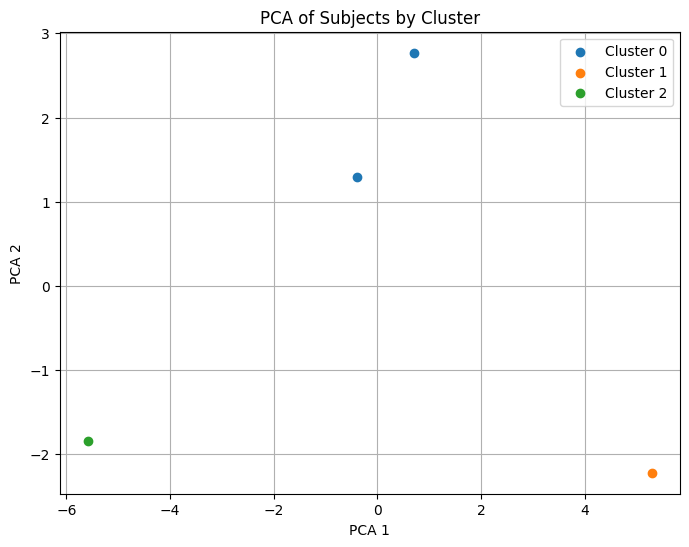

In [28]:

# STEP 8: PCA Visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for label in np.unique(labels):
    plt.scatter(X_pca[labels==label, 0], X_pca[labels==label, 1], label=f"Cluster {label}")
plt.title("PCA of Subjects by Cluster")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()


In [29]:

# STEP 9: Evaluate with Silhouette Score
score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {score:.2f}")


Silhouette Score: 0.21


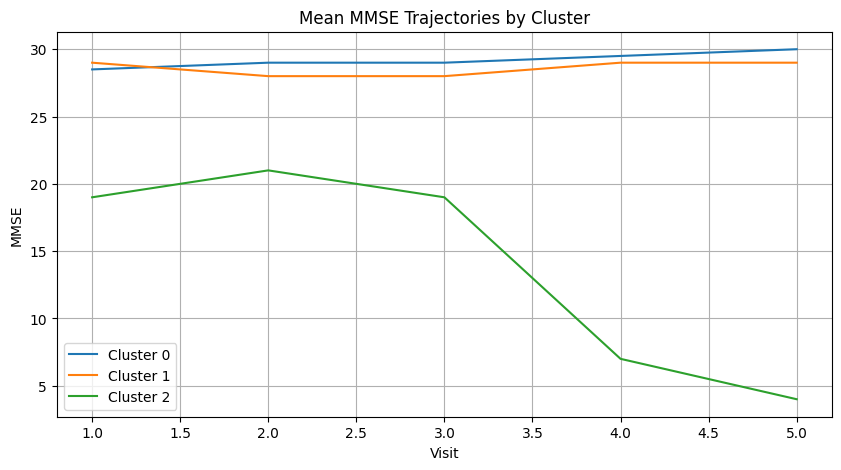

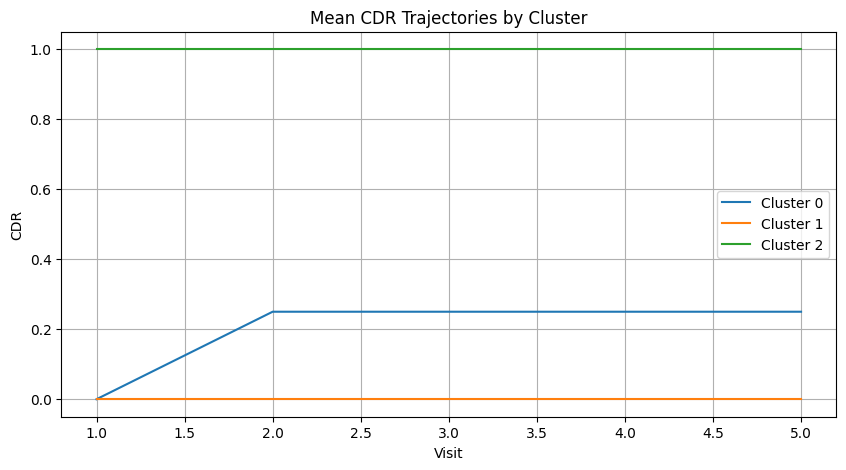

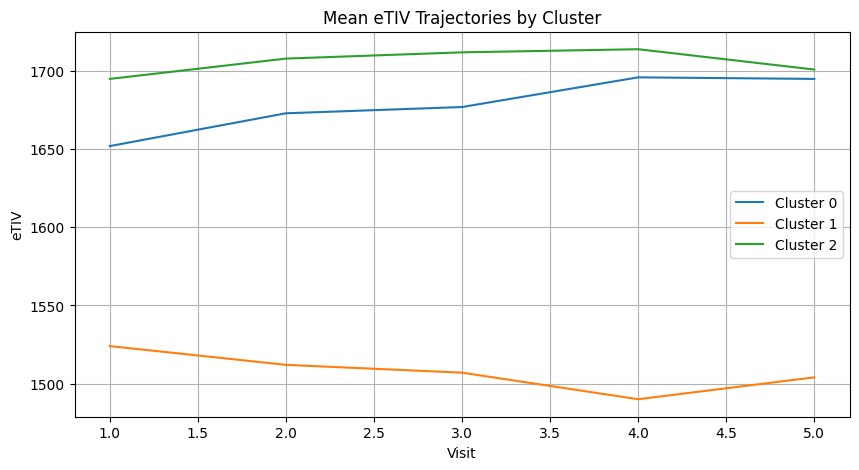

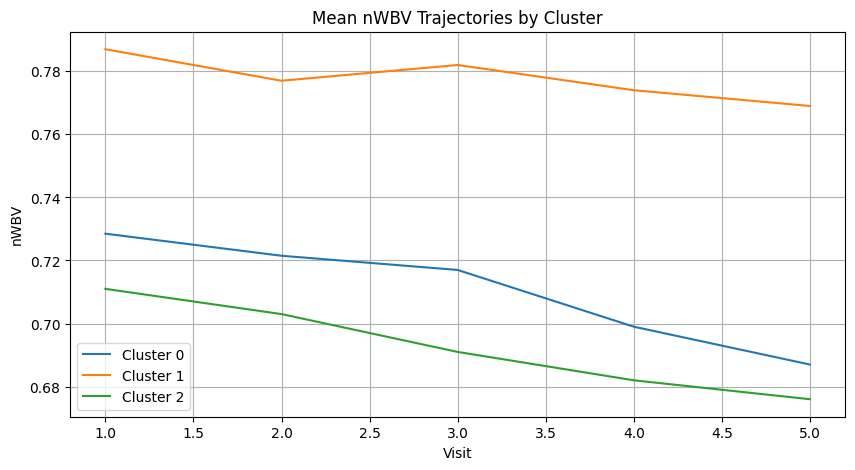

In [30]:

# STEP 10: Plot biomarker trajectories
def plot_cluster_trajectories(biomarker_name):
    df_traj = subject_series[biomarker_name].loc[df_combined.index]
    df_traj['Cluster'] = df_combined['Cluster']
    cluster_means = df_traj.groupby('Cluster').mean().T

    plt.figure(figsize=(10, 5))
    for cluster in cluster_means.columns:
        plt.plot(cluster_means.index, cluster_means[cluster], label=f'Cluster {cluster}')
    plt.title(f"Mean {biomarker_name} Trajectories by Cluster")
    plt.xlabel("Visit")
    plt.ylabel(biomarker_name)
    plt.grid(True)
    plt.legend()
    plt.show()

for biomarker in biomarkers:
    plot_cluster_trajectories(biomarker)


Saving oasis_longitudinal.csv to oasis_longitudinal (3).csv


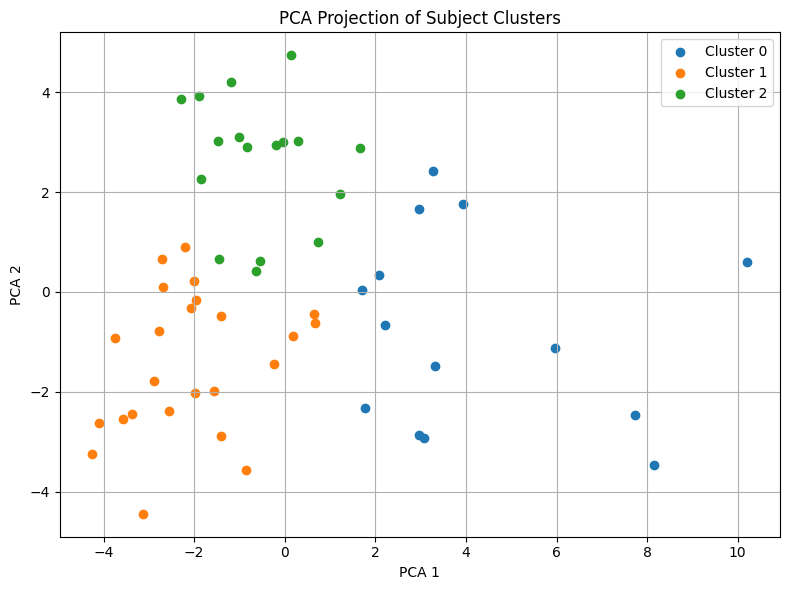

Silhouette Score: 0.27


55

In [37]:
# STEP 1: Reload and include more subjects by allowing at least 3 non-NaN values per biomarker
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# STEP 3: Upload CSV
from google.colab import files
uploaded = files.upload()

# Load the dataset (rename as needed)
df_long = pd.read_csv("oasis_longitudinal.csv")

# Select columns of interest
biomarkers = ['MMSE', 'CDR', 'eTIV', 'nWBV']
df_biomarkers = df_long[['Subject ID', 'Visit'] + biomarkers].dropna(subset=['Subject ID', 'Visit'])

# Create pivot tables per biomarker with at least 3 time points
subject_series = {}
for biomarker in biomarkers:
    pivot = df_biomarkers.pivot(index='Subject ID', columns='Visit', values=biomarker)
    pivot = pivot.loc[pivot.notna().sum(axis=1) >= 3]  # At least 3 visits
    pivot = pivot.interpolate(axis=1, limit_direction='both')  # Fill missing via interpolation
    subject_series[biomarker] = pivot

# Get common subjects with enough data for all biomarkers
common_subjects = set.intersection(*[set(df.index) for df in subject_series.values()])
combined = []

for subject in sorted(common_subjects):
    row = []
    for biomarker in biomarkers:
        row.extend(subject_series[biomarker].loc[subject].values.tolist())
    combined.append(row)

# Create feature matrix
df_combined = pd.DataFrame(combined, index=sorted(common_subjects))
df_combined.columns = [f"{b}_v{v+1}" for b in biomarkers for v in range(subject_series[biomarkers[0]].shape[1])]
df_combined = df_combined.dropna()

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_combined)

# Cluster
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df_combined['Cluster'] = labels

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA projection
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1], label=f'Cluster {label}')
plt.title("PCA Projection of Subject Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Silhouette Score
if len(np.unique(labels)) > 1 and len(labels) > len(np.unique(labels)):
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {score:.2f}")
else:
    print(f"Silhouette score not valid: only {len(np.unique(labels))} unique cluster(s) for {len(labels)} samples.")

# Show updated sample size
df_combined.shape[0]


In [38]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Store silhouette scores
scores = []
k_values = range(2, 7)  # silhouette_score requires at least 2 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    if len(np.unique(labels)) > 1:
        score = silhouette_score(X_scaled, labels)
        scores.append((k, score))
        print(f"k = {k}, Silhouette Score = {score:.2f}")
    else:
        scores.append((k, None))
        print(f"k = {k}, Invalid clustering (only one cluster assigned)")

# Identify the best k
best_k, best_score = max((item for item in scores if item[1] is not None), key=lambda x: x[1])
best_k, best_score


k = 2, Silhouette Score = 0.33
k = 3, Silhouette Score = 0.27
k = 4, Silhouette Score = 0.32
k = 5, Silhouette Score = 0.25
k = 6, Silhouette Score = 0.25


(2, np.float64(0.32874996581017546))